# Modeling

This notebook trains and evaluates multiple models on the extracted physiological features to classify stress states using cross-validation.

In [1]:
# Importing Dependecies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from glob import glob
import json
import joblib

from xgboost import XGBClassifier                       # XGBoost model
from sklearn.ensemble import RandomForestClassifier     # RandomForest model 

from sklearn.metrics import accuracy_score, f1_score, classification_report



# Disable UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Loading Feature Engineered CSV files for all Subjects

file_paths = sorted(glob("/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/data/features/S*_features.csv")) 
subject_ids = [f.split("/")[-1].split("_")[0] for f in file_paths]

In [3]:
# Variables to track Performance Metrics

accuracies = []
f1s = []
per_subject_reports = {}

## Random Forest Classifier

In [4]:
# Random Forest Classifier [LOSO Loop]

for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Filter only labels 1, 2, 3 and shift to 0-indexed for classifier
    valid_labels = [1, 2, 3]
    train_df = train_df[train_df['label'].isin(valid_labels)]
    test_df = test_df[test_df['label'].isin(valid_labels)]

    # Shift labels: 1→0, 2→1, 3→2
    train_df['label'] = train_df['label'] - 1
    test_df['label'] = test_df['label'] - 1

    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Train model
    model = RandomForestClassifier(n_estimators=30, random_state=42)
    model.fit(X_train, y_train)

    # Step 5: Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Map labels back to 1–3 for reporting
    y_pred_orig = y_pred + 1
    y_test_orig = y_test + 1

    class_names = ['Baseline (1)', 'Stress (2)', 'Amusement (3)']
    # print(classification_report(y_test_orig, y_pred_orig, target_names=class_names))

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test_orig, y_pred_orig, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")


🔄 Testing on S10 (LOSO fold 1/15)
✅ Accuracy: 0.8800 | F1 (weighted): 0.8502

🔄 Testing on S11 (LOSO fold 2/15)
✅ Accuracy: 0.8553 | F1 (weighted): 0.8431

🔄 Testing on S13 (LOSO fold 3/15)
✅ Accuracy: 0.9733 | F1 (weighted): 0.9728

🔄 Testing on S14 (LOSO fold 4/15)
✅ Accuracy: 0.8000 | F1 (weighted): 0.7496

🔄 Testing on S15 (LOSO fold 5/15)
✅ Accuracy: 0.8667 | F1 (weighted): 0.8646

🔄 Testing on S16 (LOSO fold 6/15)
✅ Accuracy: 0.9178 | F1 (weighted): 0.9090

🔄 Testing on S17 (LOSO fold 7/15)
✅ Accuracy: 0.9333 | F1 (weighted): 0.9297

🔄 Testing on S2 (LOSO fold 8/15)
✅ Accuracy: 0.5634 | F1 (weighted): 0.5403

🔄 Testing on S3 (LOSO fold 9/15)
✅ Accuracy: 0.5890 | F1 (weighted): 0.5795

🔄 Testing on S4 (LOSO fold 10/15)
✅ Accuracy: 0.8611 | F1 (weighted): 0.8405

🔄 Testing on S5 (LOSO fold 11/15)
✅ Accuracy: 0.7808 | F1 (weighted): 0.7679

🔄 Testing on S6 (LOSO fold 12/15)
✅ Accuracy: 0.8356 | F1 (weighted): 0.7644

🔄 Testing on S7 (LOSO fold 13/15)
✅ Accuracy: 0.6438 | F1 (weight

In [5]:
# Saving Summary
summary_rf = {
    "accuracies": accuracies,
    "f1s": f1s,
    "mean_accuracy": np.mean(accuracies),
    "mean_f1": np.mean(f1s)
}
with open("/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/loso_summary_rf.json", "w") as f:
    json.dump(summary_rf, f, indent=4)


# Saving Reports
with open("/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/per_subject_reports_rf.json", "w") as f:
    json.dump(per_subject_reports, f, indent=4)


# Saving model for SHAP
joblib.dump(model, "/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/model_rf.pkl")


['/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/model_rf.pkl']

In [6]:
# Reults Summary
print("\nRandomForest Summary:")
print(f"  Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"  Mean F1 Score: {np.mean(f1s):.4f}")


RandomForest Summary:
  Mean Accuracy: 0.8087
  Mean F1 Score: 0.7873


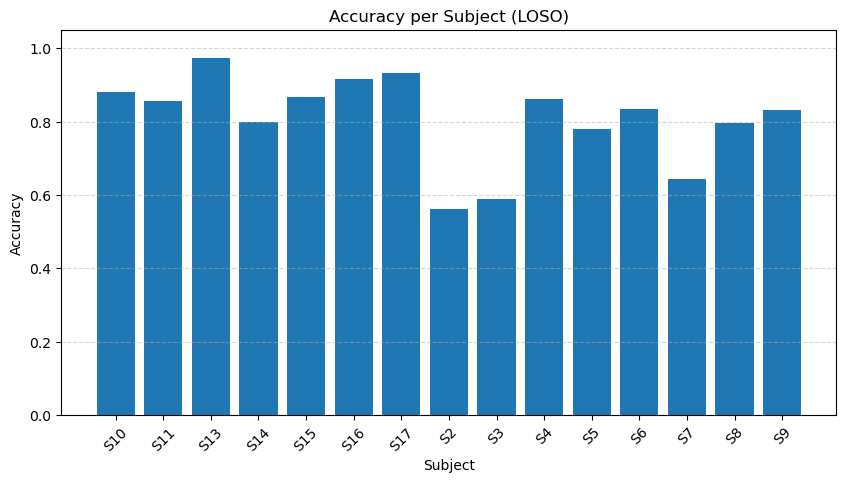

In [7]:
# Accuracy per Subject (using LOSO)

plt.figure(figsize=(10, 5))
plt.bar(subject_ids, accuracies)
plt.title("Accuracy per Subject (LOSO)")
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [8]:
importances = model.feature_importances_  # only for tree-based models
pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(10)

eda_mean               0.315536
eda_peak_count         0.174046
resp_std               0.127782
eda_std                0.079909
mean_rr                0.067791
eda_slope              0.057420
resp_zero_crossings    0.052657
rmssd                  0.042512
sdnn                   0.030697
ecg_peak_count         0.028548
dtype: float64

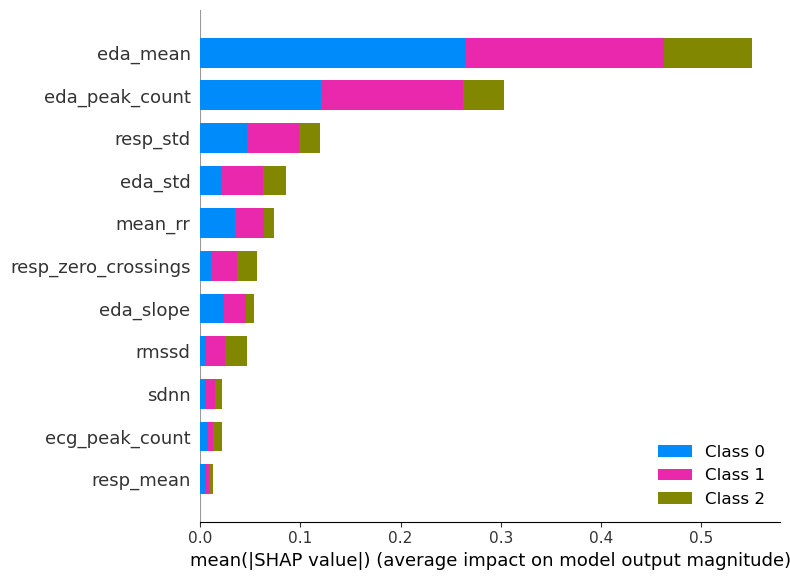

In [9]:
# Create explainer and sample a few rows
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for all classes
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

## XGBoost Model

In [10]:

for i, test_subj in enumerate(subject_ids):
    print(f"\n🔄 Testing on {test_subj} (LOSO fold {i+1}/{len(subject_ids)})")

    # Load test and train data
    test_df = pd.read_csv(file_paths[i])
    train_dfs = [pd.read_csv(f) for j, f in enumerate(file_paths) if j != i]
    train_df = pd.concat(train_dfs, ignore_index=True)

    # Filter only labels 1, 2, 3 and shift to 0-indexed for classifier
    valid_labels = [1, 2, 3]
    train_df = train_df[train_df['label'].isin(valid_labels)]
    test_df = test_df[test_df['label'].isin(valid_labels)]

    # Shift labels: 1→0, 2→1, 3→2
    train_df['label'] = train_df['label'] - 1
    test_df['label'] = test_df['label'] - 1

    # Features and Labels
    X_train, y_train = train_df.drop(columns=['label']), train_df['label']
    X_test, y_test = test_df.drop(columns=['label']), test_df['label']

    # Training Model
    model = XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False)
    model.fit(X_train, y_train)

    # Evaluating Model
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(acc)
    f1s.append(f1)
    per_subject_reports[test_subj] = classification_report(y_test, y_pred, output_dict=True)

    print(f"✅ Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")


🔄 Testing on S10 (LOSO fold 1/15)
✅ Accuracy: 0.9600 | F1 (weighted): 0.9579

🔄 Testing on S11 (LOSO fold 2/15)
✅ Accuracy: 0.8684 | F1 (weighted): 0.8644

🔄 Testing on S13 (LOSO fold 3/15)
✅ Accuracy: 0.9600 | F1 (weighted): 0.9594

🔄 Testing on S14 (LOSO fold 4/15)
✅ Accuracy: 0.7733 | F1 (weighted): 0.7461

🔄 Testing on S15 (LOSO fold 5/15)
✅ Accuracy: 0.8533 | F1 (weighted): 0.8538

🔄 Testing on S16 (LOSO fold 6/15)
✅ Accuracy: 0.9452 | F1 (weighted): 0.9420

🔄 Testing on S17 (LOSO fold 7/15)
✅ Accuracy: 0.9733 | F1 (weighted): 0.9725

🔄 Testing on S2 (LOSO fold 8/15)
✅ Accuracy: 0.5493 | F1 (weighted): 0.5361

🔄 Testing on S3 (LOSO fold 9/15)
✅ Accuracy: 0.5479 | F1 (weighted): 0.5462

🔄 Testing on S4 (LOSO fold 10/15)
✅ Accuracy: 0.9722 | F1 (weighted): 0.9722

🔄 Testing on S5 (LOSO fold 11/15)
✅ Accuracy: 0.7945 | F1 (weighted): 0.7973

🔄 Testing on S6 (LOSO fold 12/15)
✅ Accuracy: 0.8219 | F1 (weighted): 0.7509

🔄 Testing on S7 (LOSO fold 13/15)
✅ Accuracy: 0.5479 | F1 (weight

In [11]:
# Saving Summary Results
summary_xgb = {
    "accuracies": accuracies,
    "f1s": f1s,
    "mean_accuracy": np.mean(accuracies),
    "mean_f1": np.mean(f1s)
}
with open("/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/loso_summary_xgb.json", "w") as f:
    json.dump(summary_xgb, f, indent=4)


# Saving Reports
with open("/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/per_subject_reports_xgb.json", "w") as f:
    json.dump(per_subject_reports, f, indent=4)


# Saving Model for SHAP
joblib.dump(model, "/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/model_xgb.pkl")


['/Users/sarvesh/Desktop/GitHub/stress-detection-wesad/results/model_xgb.pkl']

In [12]:
# Results Summary

print("\nXGBoost Multiclass Summary:")
print(f"  Average Accuracy: {np.mean(accuracies):.4f}")
print(f"  Average F1 Score:  {np.mean(f1s):.4f}")


XGBoost Multiclass Summary:
  Average Accuracy: 0.8047
  Average F1 Score:  0.7883


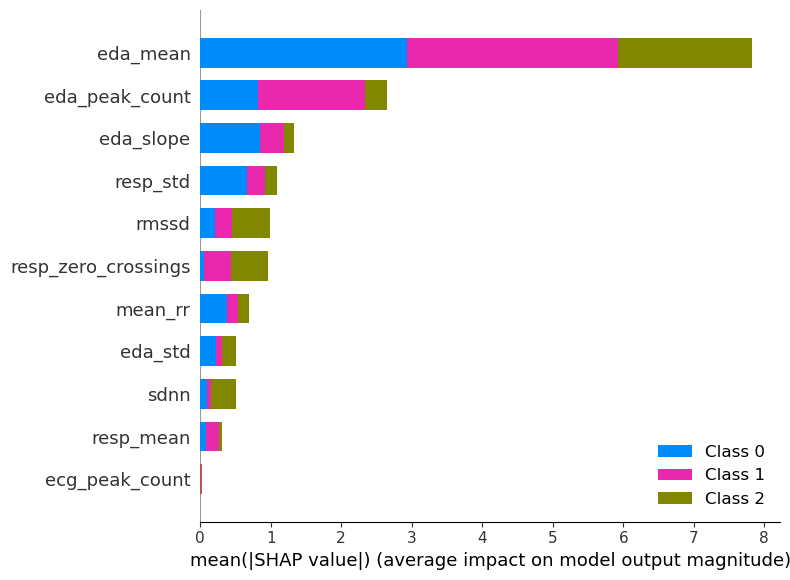

In [13]:
# Create explainer and sample a few rows
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for all classes
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [14]:
y_pred_orig = y_pred + 1
y_test_orig = y_test + 1

In [15]:
from sklearn.metrics import classification_report

class_names = ['Baseline (1)', 'Stress (2)', 'Amusement (3)']
print(classification_report(y_test_orig, y_pred_orig, target_names=class_names))


               precision    recall  f1-score   support

 Baseline (1)       1.00      1.00      1.00        39
   Stress (2)       0.66      1.00      0.79        21
Amusement (3)       1.00      0.08      0.15        12

     accuracy                           0.85        72
    macro avg       0.89      0.69      0.65        72
 weighted avg       0.90      0.85      0.80        72

